# Customize a dataset
create a class for the customized dataset

In [2]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from PIL import Image

class fundusisnotfun(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [69]:
df[df.Right_Diagnosis == 'normal fundus']

,Age,Sex,Left_Fundus,Right_Fundus,N,D,G,C,A,H,M,O,Left_Diagnosis,Right_Diagnosis
ID,,,,,,,,,,,,,,
0,69,Female,0_left.jpg,0_right.jpg,0,0,0,1,0,0,0,0,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,1,0,0,0,0,0,0,0,normal fundus,normal fundus
8,59,Male,8_left.jpg,8_right.jpg,1,0,0,0,0,0,0,0,normal fundus,normal fundus
10,70,Male,10_left.jpg,10_right.jpg,0,0,0,0,0,0,0,1,epiretinal membrane,normal fundus
29,59,Male,29_left.jpg,29_right.jpg,0,0,0,0,0,0,0,1,epiretinal membrane,normal fundus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4642,52,Male,4642_left.jpg,4642_right.jpg,0,1,0,0,0,0,0,0,mild nonproliferative retinopathy,normal fundus
4644,60,Female,4644_left.jpg,4644_right.jpg,0,1,0,0,0,0,0,0,mild nonproliferative retinopathy,normal fundus
4660,51,Male,4660_left.jpg,4660_right.jpg,0,1,0,0,0,0,0,0,mild nonproliferative retinopathy,normal fundus


Dataset preparation

We seperate the left/right eyes as two samples and save the labels as csv file

In [84]:
from packages.small_batch_images import *
df = load_annotation()
healthy_labels = pd.DataFrame(columns=['image', 'age'])
unhealthy_labels = healthy_labels.copy()
# Seperate the each healthy sample into two samples
i = 0; j = 0
for ind in df.index:
    row = df.loc[ind]
    # healthy/unhealthy set construction
    if os.path.isfile('images_cropped/{}'.format(row.Left_Fundus)):
        if row.Left_Diagnosis == 'normal fundus':
            healthy_labels.loc[i] = {'image': row['Left_Fundus'], 'age': row['Age']}
            i+=1
        else:
            unhealthy_labels.loc[j] = {'image': row['Left_Fundus'], 'age': row['Age']}
            j+=1
    if os.path.isfile('images_cropped/{}'.format(row.Right_Fundus)):
        if row.Right_Diagnosis == 'normal fundus':
            healthy_labels.loc[i] = {'image': row['Right_Fundus'], 'age': row['Age']}
            i+=1
        else:
            unhealthy_labels.loc[j] = {'image': row['Right_Fundus'], 'age': row['Age']}
            j+=1
# save as csv file
healthy_labels.to_csv('healthy_labels.csv', index=False)
unhealthy_labels.to_csv('unhealthy_labels.csv', index=False)

In [85]:
healthy_labels.head()

,image,age
0,0_right.jpg,69
1,1_left.jpg,57
2,1_right.jpg,57
3,3_left.jpg,66
4,8_left.jpg,59


In [86]:
# for each age there are at least 2 sample (in fact it's L/R eyes)
healthy_labels.groupby('age').count().min()

image    1
dtype: int64

In [87]:
len(healthy_labels)

2463

In [103]:
# Use stratified method to select samples, leave 20% for testing, together with unhealthy ones
healthy_labels = pd.read_csv('healthy_labels.csv')
train = healthy_labels.groupby('age', group_keys=False).apply(lambda x: x.sample(min(len(x), 65)))
test = healthy_labels[~healthy_labels.index.isin(train.index)]
test = pd.concat((test, unhealthy_labels.sample(1000)))
train.to_csv('labels_train.csv', index=False)
test.to_csv('labels_test.csv', index=False)
(len(train), len(test))

(2079, 1384)

Datasets creation

In [104]:
# Function to calculate mean and std
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data)
        channels_squared_sum += torch.mean(data**2)
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    return mean, std

Feature batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


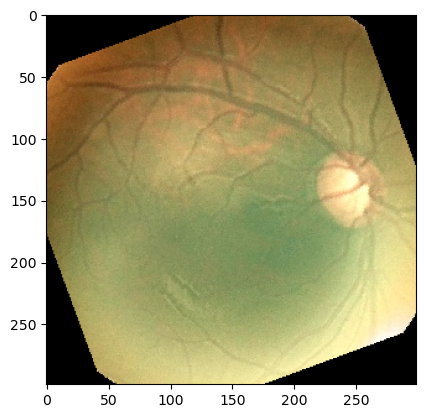

Label: 33


In [108]:
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

plain_transform = T.Compose([
        T.ToTensor()]
)

training_data_plain = fundusisnotfun(img_dir='images_cropped', transform=plain_transform, annotations_file='labels_train.csv')
test_data = fundusisnotfun(img_dir='images_cropped', transform=plain_transform,annotations_file='labels_test.csv')

train_loader_plain = DataLoader(training_data_plain, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)
mean, std = get_mean_std(train_loader_plain)
mean = torch.tensor([mean], dtype=torch.float32)
std = torch.tensor([std], dtype=torch.float32)

# start augmentation
color_jitter = T.ColorJitter(brightness=0.2, contrast=0.1)
train_transform_augs = T.Compose([
        T.ToTensor(),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation([0, 180]),
        # T.RandomResizedCrop(size=244, scale=(0.9,1),antialias=True),
        # T.RandomApply([color_jitter], p=0.8),
        # T.Normalize(list(mean), list(std))])
])

training_data = fundusisnotfun(img_dir='images_cropped', transform=train_transform_augs, annotations_file='labels_train.csv')
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T)
plt.show()
print(f"Label: {label}")

# Transfer Learning models

Appetizer 1: copy KNN model from deep learning exercise A09 task1
The classes are actually labels

In [23]:
import numpy as np
import torch
import torchvision
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from torch import nn

device = 'cuda'

class KnnConvnet():
    def __init__(self, model, device='cpu', distance='cosine'):
        self.device = device
        self.model = model.to(device)
        self.model.eval()
        self.embeds_train = None
        self.lab_train = None
        self.lab_test = None
        self.embeds_test = None
        self.distance = distance

    def get_features(self, mode='train'):
        """Returns the embeddings of the train or test set.
        Args:
            mode (str, optional): "train" or "test". Defaults to 'train'.
        """
        assert self.embeds_train is not None, 'Training embedding are not computed yet.'
        assert self.embeds_test is not None, 'Test embedding are not computed yet.'
        if mode=='train':
            return self.embeds_train, self.lab_train
        else:
            return self.embeds_test, self.lab_test

    def set_features(self, embeds, labels, mode='train'):
        """Sets the train or test embeddings and their labels."""
        if mode=='train':
            self.embeds_train = embeds
            self.lab_train = labels
        else:
            self.embeds_test = embeds
            self.lab_test = labels

    @torch.no_grad()
    def extract_features(self, loader):
        """Infers features from the provided image loader.
        Args:
            loader: train or test loader
        Returns: 3 tensors of all: features, labels
        """
        features = []
        label_lst = []
        for input_tensor, label in loader:
            h = self.model(input_tensor.to(self.device))
            features.append(h)
            label_lst.append(label)
        h_total = torch.cat(features)
        label_total = torch.cat(label_lst)
        return h_total, label_total

    @torch.no_grad()
    def fit(self, features, labels, k):
        """Fits the provided features to create a KNN classifer (i.e. self.cls object).
        Args:
            features: [... , dataset_size, feat_dim]
            labels: [... , dataset_size]
            k: number of nearest neighbours for majority voting
        """
        features_np, labels_np = self.fix_dims(features, labels)
        self.cls = KNeighborsClassifier(k, metric=self.distance).fit(features_np, labels_np)

    def fix_dims(self, features, labels):
        """Reshapes the features and labels to have a shapes of
        [dataset_size, feat_dim], [dataset_size] respectivly
        """
        features = features.view(-1, features.shape[-1]).cpu().numpy()
        labels = labels.view(-1).cpu().numpy()
        return features, labels

    def accuracy(self, features, labels):
        """Uses the features to compute the accuracy of the classifier (i.e. self.cls object)."""
        features_np, labels_np = self.fix_dims(features, labels)
        acc = 100 * np.mean(self.cls.predict(features_np) == labels_np)
        return acc

    @torch.no_grad()
    def execute(self, train_loader, test_loader=None, k=10):
        if self.embeds_train is None:
            embeds_train, lab_train = self.extract_features(train_loader)
            self.set_features(embeds_train, lab_train, mode='train')

        self.fit(self.embeds_train, self.lab_train, k)
        train_acc = self.accuracy(self.embeds_train, self.lab_train)

        if test_loader is not None:
            if self.embeds_test is None:
                embeds_test, lab_test = self.extract_features(test_loader)
                self.set_features(embeds_test, lab_test, mode='test')

            test_acc = self.accuracy(self.embeds_test, self.lab_test)
            return train_acc, test_acc

        return train_acc

def test_knn():
    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    # model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)
    knn_cls = KnnConvnet(model, device=device)
    for k in 1, 5, 15, 60:
        print("plain dataset:")
        train_acc, test_acc = knn_cls.execute(train_loader, test_loader, k=k)
        print(f"train acc: {train_acc:.2f}%, test acc: {test_acc:.2f}%")
        print("augmented dataset:")
        train_acc, test_acc = knn_cls.execute(train_loader, test_loader, k=k)
        print(f"train acc: {train_acc:.2f}%, test acc: {test_acc:.2f}%")

test_knn()

plain dataset:


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[64, 1, 299, 299] to have 3 channels, but got 1 channels instead

Appetizer 2: copy KNN model from deep learning exercise A09 task2

In [62]:
def get_model(modelname="resnet18", pretrained=True):
    ### START CODE HERE ### (approx. 2 lines)
    model = getattr(torchvision.models, modelname)(pretrained=pretrained)
    model.fc = nn.Identity()
    ### END CODE HERE ###
    return model

def run_knn_hp_tuning(model, train_loader, test_loader,
                        range_k = [5, 10, 15, 20], device='cpu', modelname='resnet'):
    train_acc_all = []
    val_acc_all = []
    knn_cls = KnnConvnet(model, device)

    print("Calc. train features")
    ### START CODE HERE ### (approx. 4 lines)
    train_embeds, labels = knn_cls.extract_features(train_loader)
    knn_cls.set_features(train_embeds, labels, mode='train')
    # torch.save(train_embeds, f"./{modelname}_embeds_train.pt")
    # torch.save(labels, f"./{modelname}_labels_train.pt")
    sub_idx = np.random.choice(len(train_embeds), 10000)
    train_embeds_sub = train_embeds[sub_idx]
    labels_sub = labels[sub_idx]
    ### END CODE HERE ###

    print("Calc. test features")
    ### START CODE HERE ### (approx. 4 lines)
    test_embeds, test_labels = knn_cls.extract_features(test_loader)
    knn_cls.set_features(test_embeds, test_labels, mode='train')
    # torch.save(test_embeds, f"./{modelname}_embeds_test.pt")
    # torch.save(test_labels, f"./{modelname}_labels_test.pt")
    ### END CODE HERE ###

    for k in range_k:
        ### START CODE HERE ### (approx. 3 lines)
        knn_cls.fit(train_embeds, labels, k)
        train_acc_all.append(knn_cls.accuracy(train_embeds_sub, labels_sub))
        val_acc_all.append(knn_cls.accuracy(test_embeds, test_labels))
        ### END CODE HERE ###
    return train_acc_all, val_acc_all

backbone_r18 = get_model("resnet18")
backbone_r50 = get_model("resnet50")

range_k = [5, 10, 30, 50]
train_acc_r18, val_acc_r18 = run_knn_hp_tuning(backbone_r18, train_loader_plain,
    test_loader, range_k, device, modelname="resnet18")

train_acc_r50, val_acc_r50 = run_knn_hp_tuning(backbone_r50, train_loader,
    test_loader, range_k, device, modelname="resnet50")

c:\Users\Admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-

Calc. train features
Calc. test features
Calc. train features
Calc. test features


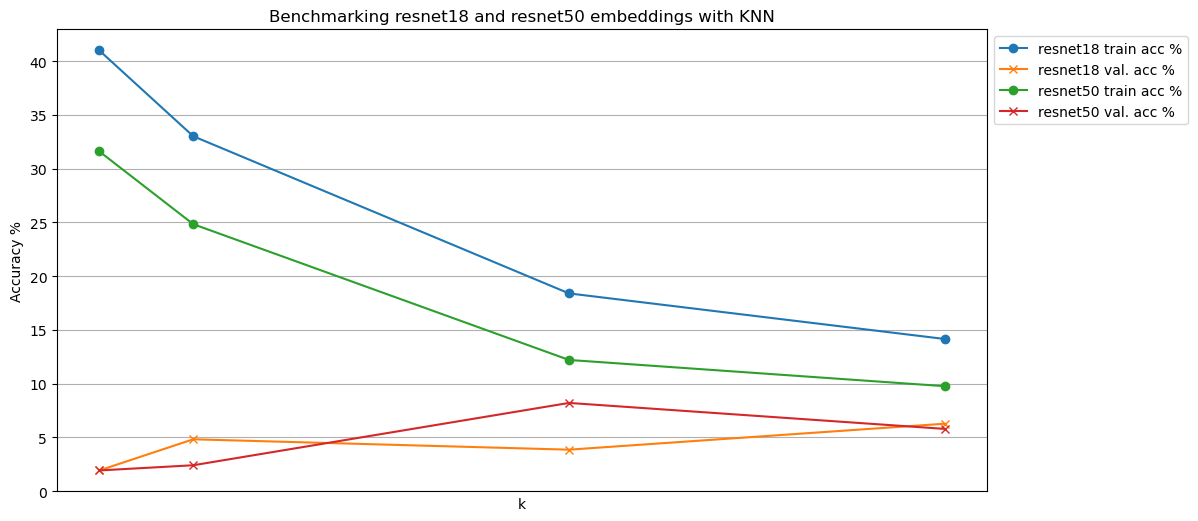

In [235]:
import matplotlib.pyplot as plt

def plot_knn_accs(range_k, train_acc_all, val_acc_all,  modelname='resnet18'):
    plt.plot(range_k, train_acc_all, marker='o', label=f'{modelname} train acc %')
    plt.plot(range_k , val_acc_all, marker='x', label=f"{modelname} val. acc %")

plt.figure(figsize=(12, 6))
plot_knn_accs(range_k, train_acc_r18, val_acc_r18,  modelname='resnet18')
plot_knn_accs(range_k, train_acc_r50, val_acc_r50,  modelname='resnet50')
plt.legend( bbox_to_anchor=(1,1), loc="upper left")
plt.grid()
plt.xticks([]) # hides x axis
plt.xlabel("k")
plt.ylabel(f"Accuracy %")
plt.title("Benchmarking resnet18 and resnet50 embeddings with KNN")
plt.show()

Apparently KNN is not suitable in this case.

In [106]:
import packages.utils
from packages.utils import *
import importlib
importlib.reload(packages.utils)

<module 'packages.utils' from 'c:\\Users\\Admin\\Documents\\GitHub\\fundusfunfunf\\packages\\utils.py'>

In [123]:
# create model
class ResSoftMax(nn.Module):
    def __init__(self):
        super(ResSoftMax, self).__init__()
        ### START CODE HERE ### (approx. 3 lines)
        self.backbone = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights.DEFAULT)
        # self.backbone = torchvision.models.resnet50()
        # self.backbone = torchvision.models.vgg16(weights = torchvision.models.VGG16_Weights.IMAGENET1K_V1)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.backbone.fc = nn.Identity()
        self.addition = nn.Sequential(
            # nn.AvgPool2d(kernel_size=12),
            nn.Linear(in_features=512, out_features=100),
            nn.Softmax()
        )
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (approx. 1 lines)
        out = self.addition((self.backbone(x)))
        return out
        ### END CODE HERE ###

# Initialize model and optimizer
num_epochs = 200
### START CODE HERE ### (approx. 2 lines)
model = ResSoftMax()

optimizer = torch.optim.Adam(model.addition.parameters(), lr=1e-5, weight_decay=0.003, betas=(0.9, 0.999))
### END CODE HERE ###

dict_log = train(model, optimizer, num_epochs, train_loader, test_loader, device)

c:\Users\Admin\Documents\GitHub\fundusfunfunf\packages\utils.py:40: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  ages = torch.range(0, outputs.shape[1]-1).to(device)


Init MAE of the model: Train:10.915 	 Val:10.200663


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\Admin\Documents\GitHub\fundusfunfunf\packages\utils.py:99: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  ages = torch.range(0, outputs.shape[1]-1).to(device)
  0%|          | 0/200 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [122]:
from torchsummary import summary
summary(model, (3, 299 ,299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5           [-1, 64, 75, 75]          36,864
       BatchNorm2d-6           [-1, 64, 75, 75]             128
              ReLU-7           [-1, 64, 75, 75]               0
            Conv2d-8           [-1, 64, 75, 75]          36,864
       BatchNorm2d-9           [-1, 64, 75, 75]             128
             ReLU-10           [-1, 64, 75, 75]               0
       BasicBlock-11           [-1, 64, 75, 75]               0
           Conv2d-12           [-1, 64, 75, 75]          36,864
      BatchNorm2d-13           [-1, 64, 75, 75]             128
             ReLU-14           [-1, 64,

c:\Users\Admin\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
